In [3]:
%config InlineBackend.figure_formats = ['svg']

import pandas as pd
import matplotlib.pyplot as plt
import math

In [14]:
#transactionLabels = ["getDeliveryNotification", "itemviewer_getMenu", "AMQP Consumer"]

figureConfigs = {
    "syncAsync": {
        "folder": "syncAsync/v",
        "transactionLabels": ["AMQP Consumer"],
        "excelPrefix": "/metricsorderSyncAsync_V",
        "metricsiloc": [0,5,6,7,19,20],
        "figsize": (15,18),
        "label-fontsize": 35,
        "legend-position": 1,
        "x-label-text": "Throughput/Metric Value",
        "fileName": "syncAsync.pdf",
        "versions": [1,2,3,4]
    },
    "numberofServices": {
        "folder": 'numberofServices/v',
        "transactionLabels": ["AMQP Consumer"],
        "excelPrefix": "/metricsorderNumberOfServices_V",
        "metricsiloc": [0,4,5,6,7,8,9,13,15,18,21,23],
        "figsize": (13,19),
        "label-fontsize": 30,
        "legend-position": 4,
        "x-label-text": "Throughput/Metric Value",
        "fileName": "numberofservices.pdf",
        "versions": [1,2,3]
    },
    "numberofServicesEffects": {
        "folder": 'numberofServices/v',
        "transactionLabels": ["AMQP Consumer"],
        "excelPrefix": "/metricsorderNumberOfServices_V",
        "figsize": (13,11),
        "metricsiloc": [4,14,18,19,20,23],
        "label-fontsize": 30,
        "legend-position": 4,
        "x-label-text": "Metric Value",
        "fileName": "numberofservicesEffects.pdf",
        "versions": [1,2,3]
    },
    "numberofServicesNoWork": {
        "folder": 'numberofServicesNoWork/v',
        "transactionLabels": ["AMQP Consumer"],
        "excelPrefix": "/metricsorderNumberOfServicesnoWork_V",
        "figsize": (11,6),
        "metricsiloc": [0,21,23],
        "label-fontsize": 30,
        "legend-position": 1,
        "x-label-text": "Throughput/Metric Value",
        "fileName": "numberofservicesNoWork.pdf",
        "versions": [1,2,3]
    }
}


# change the config here based on the available configs above
config = figureConfigs['numberofServicesNoWork']



versionsToView = config["versions"]
transactionLabels = ["AMQP Consumer"]

def loadMetrics(version):
    metrics = pd.read_excel(config["folder"] + str(version) + config["excelPrefix"] + str(version) + '.xlsx', 1)

    metrics = metrics.rename(columns={'Unnamed: 0': "metric"})
    return metrics

def getTransactions(version):

    transactions = pd.read_csv(config["folder"] + str(version)  +'/result.jtl')

    transactions['timeStamp'] = pd.to_datetime(transactions['timeStamp'], unit='ms')

    dict = {}

    for label in config["transactionLabels"]:
        tmp = transactions.loc[transactions['label'] == label]

        tmp = tmp[tmp['success'] == True]
        

        startEnd = tmp.iloc[[0, -1]]


        duration = startEnd.iloc[1]['timeStamp'] - startEnd.iloc[0]['timeStamp']

        dict[label] =  len(tmp) / duration.seconds #[len(tmp) / duration.seconds]
    
    dict["Throughput of notifyClientOfDelivery"] = dict.pop("AMQP Consumer")

    return dict

def combineThroughput(versions):

    res = pd.DataFrame()

    for version in versions:
        p = getTransactions(version)

        frame = pd.DataFrame.from_dict(p, orient='index',
                       columns=['V' + str(version)])

        res = pd.concat([res, frame], axis=1)

    return res

def combinePerformance(versions):
    allSeries = []
    for version in versions:
        perf = pd.read_csv(config["folder"] + str(version) + '/podPerformance.csv')

        perf['timestamp'] = pd.to_datetime(perf['timestamp'])

        meanPodCpu = perf.pivot(index='timestamp', columns='pod', values='cpu').mean()

        res = pd.Series()
        res['cpu (std)'] = meanPodCpu.std() / 10000000
        res['memory (mean)'] = perf['memory'].mean() / 100000
        res['memory (std)'] = perf['memory'].std() / 100000

        allSeries.append(res.rename("V" + str(version)))
    
    return pd.concat(allSeries, axis=1)

def combineMetrics(versions):
    df = pd.DataFrame()

    for version in versions:
        m = loadMetrics(version)

        df['metric'] = m['metric']
        df['V' + str(version)] = m['orderFood']

    return df

def addLineBreak(someString):
    splitted = someString.split(' ')
    if (len(splitted) <= 2):
        return someString
    numberOfSpaces = len(splitted) - 1
    half = math.ceil(numberOfSpaces / 2) + 1
    splitted[half] = "\n" + splitted[half]
    return ' '.join(splitted)


In [7]:
combineThroughput(versionsToView)

,V1,V2,V3
Throughput of notifyClientOfDelivery,6.921348,6.314607,5.865169


In [8]:
combinePerformance(versionsToView)


C:\Users\Robin\AppData\Local\Temp\ipykernel_17412\3443147577.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()
C:\Users\Robin\AppData\Local\Temp\ipykernel_17412\3443147577.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()
C:\Users\Robin\AppData\Local\Temp\ipykernel_17412\3443147577.py:87: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()


,V1,V2,V3
cpu (std),7.926220,8.503727,8.978086
memory (mean),1.556096,1.607829,1.514906
memory (std),0.263359,0.208025,0.243359


C:\Users\Robin\AppData\Local\Temp\ipykernel_8996\2364793582.py:117: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()
C:\Users\Robin\AppData\Local\Temp\ipykernel_8996\2364793582.py:117: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()
C:\Users\Robin\AppData\Local\Temp\ipykernel_8996\2364793582.py:117: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  res = pd.Series()
c:\Python311\Lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
c:\Python311\Lib\site-packages\openpyxl\st

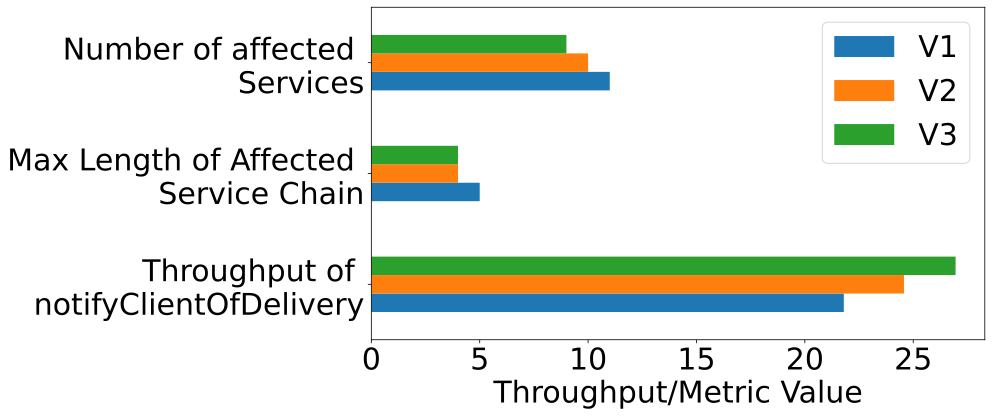

In [15]:
throughput = combineThroughput(versionsToView)

throughput = throughput.reset_index()
throughput = throughput.rename(columns={"index": "metric"})

performance = combinePerformance(versionsToView)
performance['metric'] = performance.index

combined = pd.concat([throughput, performance, combineMetrics(versionsToView)]).reset_index(drop=True)

combined = combined.iloc[config["metricsiloc"]]

#combined
ax = combined.plot.barh(x='metric', figsize=config["figsize"], fontsize= config["label-fontsize"])

y_axis = ax.axes.set_ylabel(None)

ax.set_xlabel(config["x-label-text"],fontdict={'fontsize': config["label-fontsize"]})

#split tick labels based on whitespaces and add line break at the middle space
metricLabels = map(lambda obj: addLineBreak(obj.get_text()), ax.get_yticklabels())

ax.set_yticklabels(labels=metricLabels)

ax.legend(loc=config["legend-position"], prop={'size': 30})

plt.savefig(config["fileName"], bbox_inches = 'tight')


<AxesSubplot: xlabel='metric', ylabel='metric'>

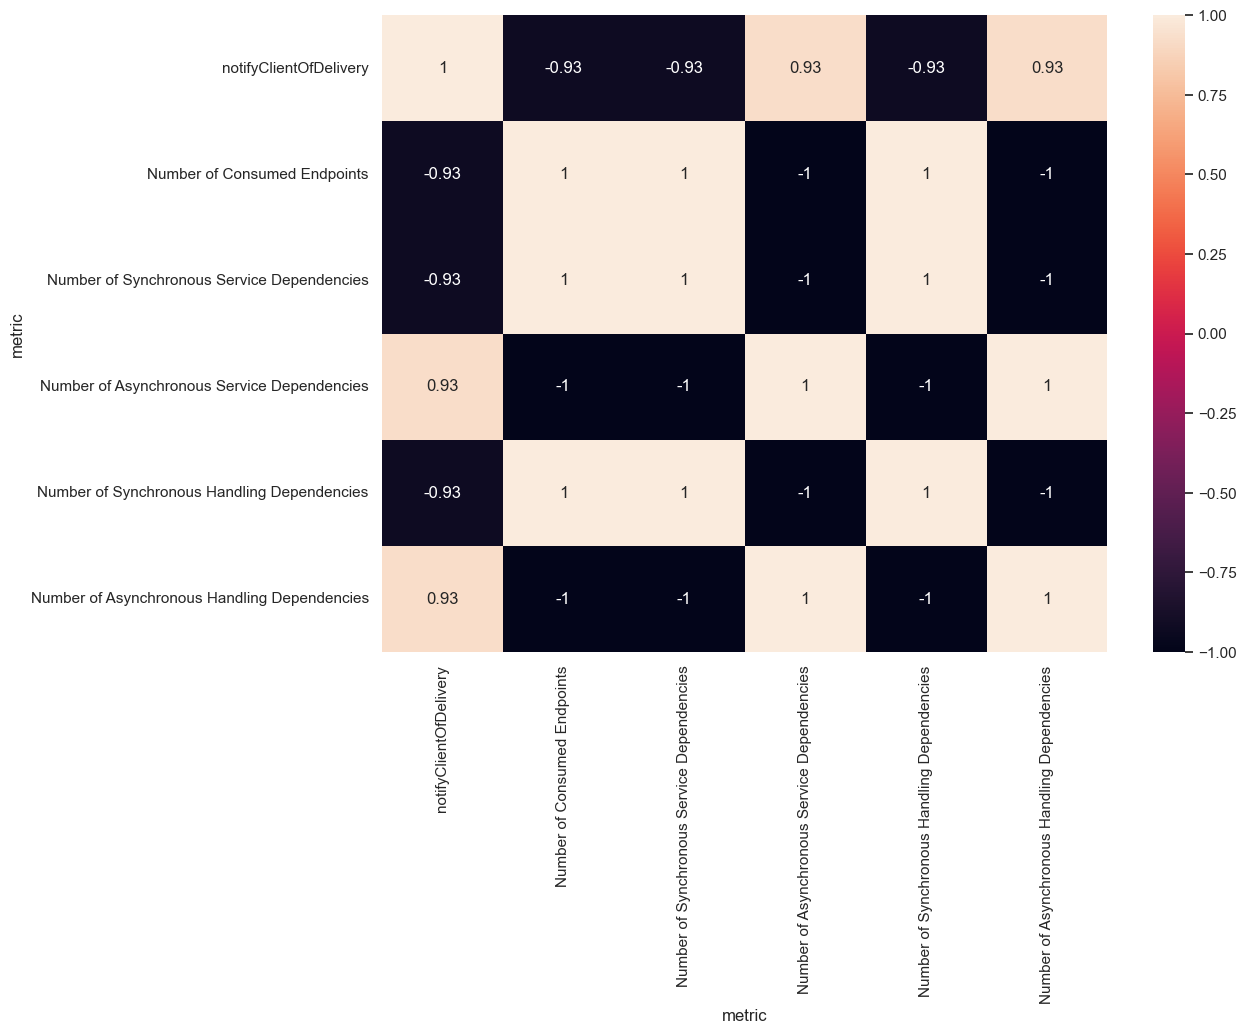

In [10]:
import seaborn as sns

temp = combined.T #.plot.bar(x='metric', figsize=(16,8))

temp = temp[[0,5,6,7,19,20]]

new_header = temp.iloc[0] #grab the first row for the header
temp = temp[1:] #take the data less the header row
temp.columns = new_header #set the header row as the df header

temp = temp.astype(float)

normalized_df=(temp-temp.mean())/temp.std()

# pearson kendall
corr = normalized_df.corr(method='pearson')

sns.set(rc={'figure.figsize':(11.7,8.27)})

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, annot=True)